## Risky Payers Prediction

In [63]:
import pandas as pd 

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set default styling and color for all plots
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#2E8B57', '#66CDAA', '#3CB371', '#8FBC8F', '#006400'])  # Green shades
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.grid'] = True  
mpl.rcParams['grid.alpha'] = 0.3  

# features engineering and modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle

### Data Understanding and Loading


In [2]:
df = pd.read_csv("CC GENERAL 3.csv")
df.head(5)

,CUST_ID,GENDER,LOCATION,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE,IS_RISKY_PAYER
0,C10001,Female,Nablus,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,12,1
1,C10002,Male,Nablus,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,12,0
2,C10003,Male,Jenin,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,12,1
3,C10004,Male,Tulkarm,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,12,0
4,C10005,Male,Tulkarm,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,12,1


In [3]:
df.shape

(8950, 20)

In [21]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

binary_columns = [col for col in df.columns if df[col].nunique() == 2]
categorical_features += binary_columns
categorical_features = categorical_features + ['TENURE']

numerical_features = [col for col in numerical_features if col not in categorical_features]

print("Categorical Features:\n", pd.Index(categorical_features))
print("Numerical Features:\n", pd.Index(numerical_features))

categorical_df = df[categorical_features] 
numerical_df = df[numerical_features] 

Categorical Features:
 Index(['CUST_ID', 'GENDER', 'LOCATION', 'GENDER', 'IS_RISKY_PAYER', 'TENURE'], dtype='object')
Numerical Features:
 Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS'],
      dtype='object')


In [22]:
num_users = df['CUST_ID'].nunique()
num_cities = df['LOCATION'].nunique()
gender_counts = df['GENDER'].value_counts()
tenure = df['TENURE'].value_counts()


basic_summary = {
    'Total Unique Users': num_users,
    'Total Unique Cities': num_cities,
    'Gender Distribution': gender_counts.to_dict(),
    'Tenure Distribution': tenure.to_dict(),
}
basic_summary

# no duplicates in users, not a concerning gender bias, most cards have 12 months tenure. 

{'Total Unique Users': 8950,
 'Total Unique Cities': 6,
 'Gender Distribution': {'Male': 5272, 'Female': 3678},
 'Tenure Distribution': {12: 7584,
  11: 365,
  10: 236,
  6: 204,
  8: 196,
  7: 190,
  9: 175}}

### Data Preprocessing and Exploration

#### Missing Values 

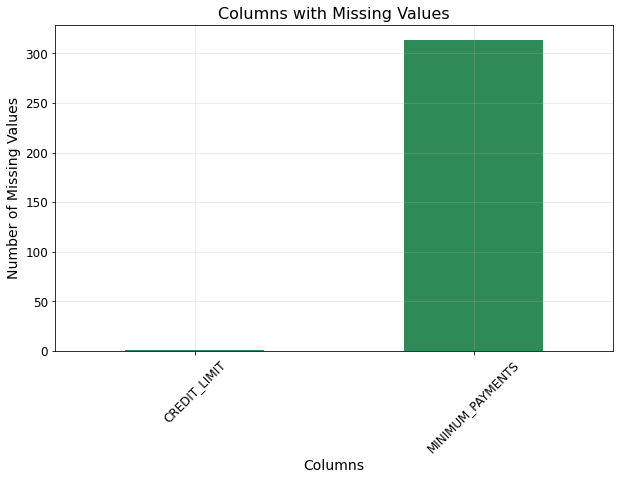

In [7]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Plotting missing values
missing_values.plot(kind='bar')
plt.title("Columns with Missing Values")
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.show()

In [8]:
missing_percentage = (missing_values / 8950) * 100
missing_percentage

CREDIT_LIMIT        0.011173
MINIMUM_PAYMENTS    3.497207
dtype: float64

The low percentages indicate minimal missing values. 
<br>we'll choose a handling method based on each column's characteristics.

In [9]:
df[['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']].describe()

,CREDIT_LIMIT,MINIMUM_PAYMENTS
count,8949.000000,8637.000000
mean,4494.449450,864.206542
std,3638.815725,2372.446607
min,50.000000,0.019163
25%,1600.000000,169.123707
50%,3000.000000,312.343947
75%,6500.000000,825.485459
max,30000.000000,76406.207520


we notice: <br>
* Right-Skewed Distribution: Both columns have a mean notably higher than the median which indicates skeweness
* Outliers: High standard deviations and large ranges, especially for MINIMUM_PAYMENTS (max = 76,406.21) means there's outliers.
<br><br>
Given the skew and outliers, *median* is the most suitable method to handle missing values, as it better represents central tendency in skewed data.

In [10]:
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median(), inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

#### EDA

In [23]:
numerical_df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.282473,1733.143852,844.906767
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.646702,2895.063757,2332.792322
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,788.713501
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520


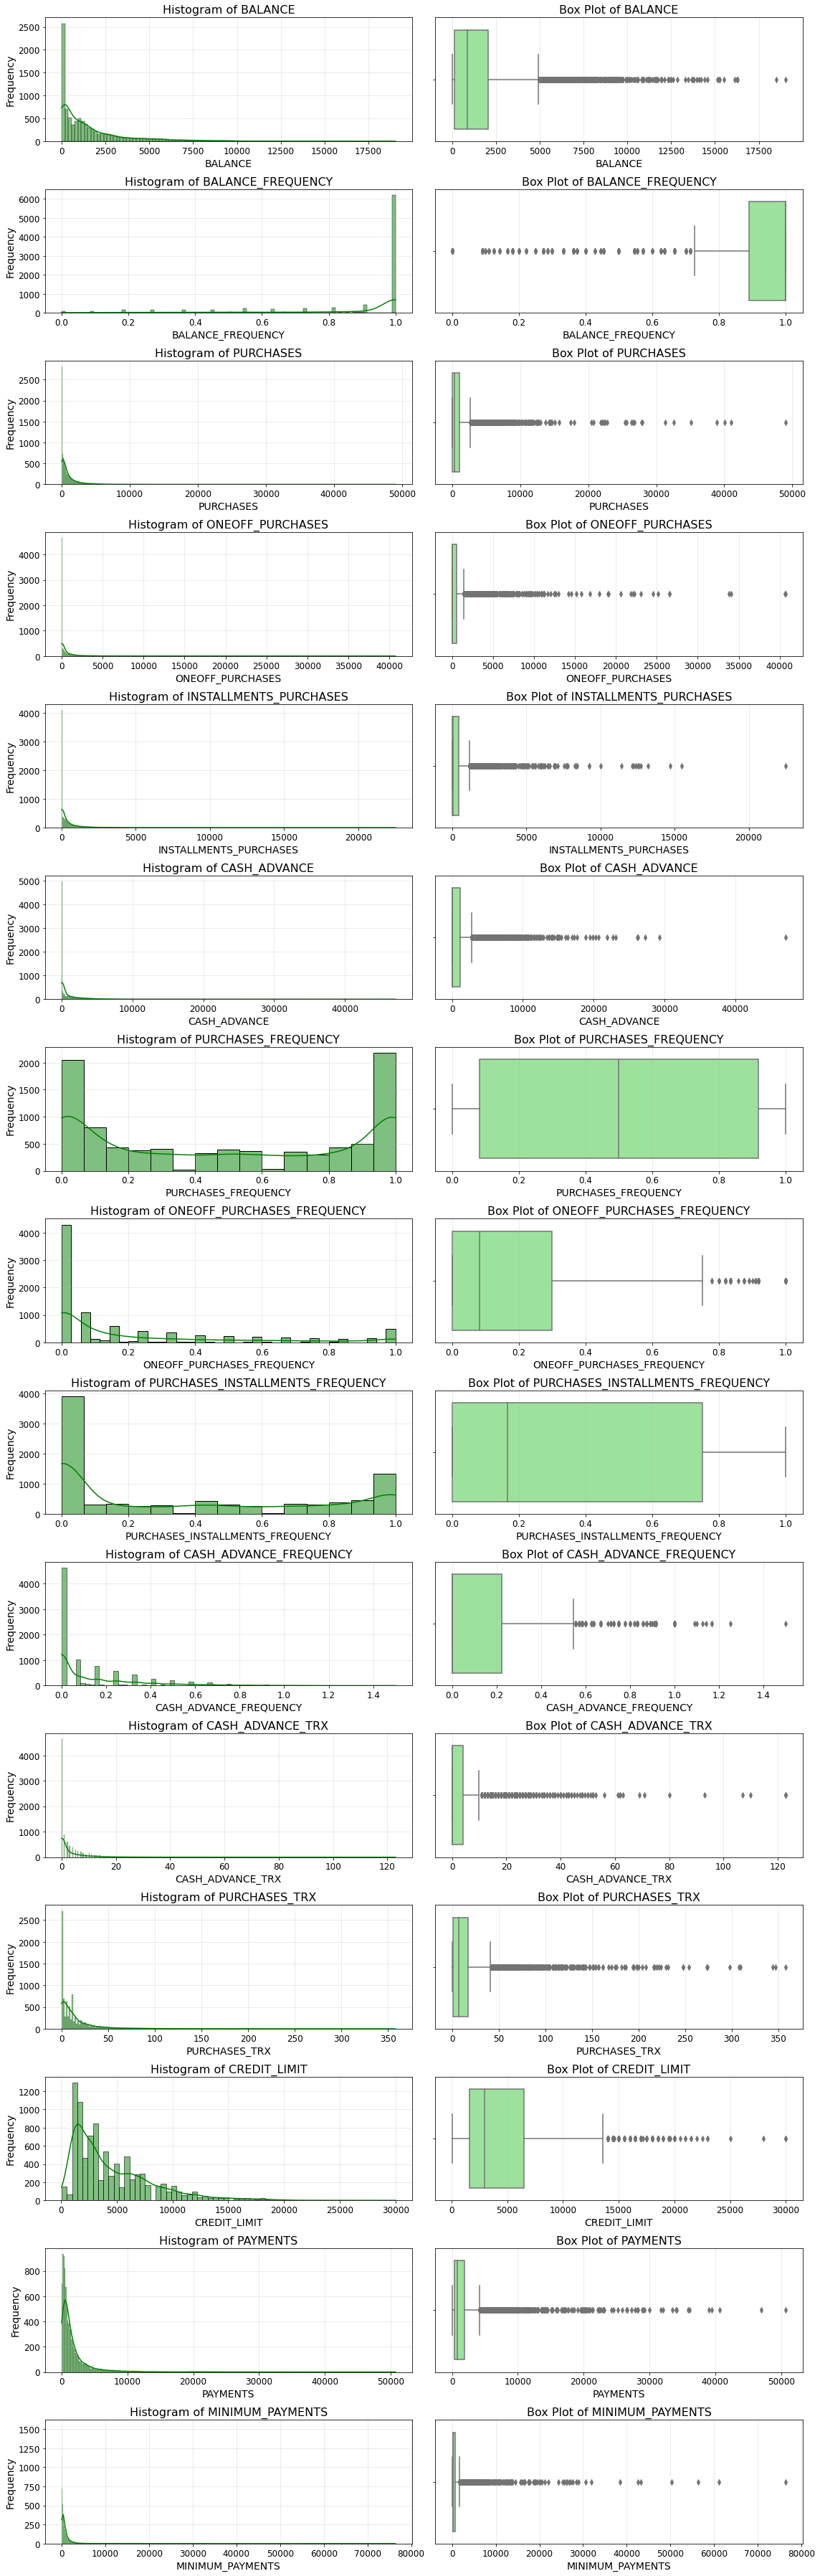

In [24]:
plt.figure(figsize=(16, 50))

for i, col in enumerate(numerical_features, 1):
    # Histogram
    plt.subplot(len(numerical_features), 2, 2*i - 1)
    sns.histplot(df[col], kde=True, color='green', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # Box plot
    plt.subplot(len(numerical_features), 2, 2*i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


##### Skewness and Outliers

1. PURCHASES
   - Mean: 1003.20 vs. Median (50th percentile): 361.28 — right skewness.
   - Range: Maximum of 49,039.57 - extreme outliers.

2. ONEOFF_PURCHASES
   - Mean: 592.44 vs. Median: 38.00 — right skewness.
   - Range: Maximum of 40,761.25 - outliers.

3. INSTALLMENTS_PURCHASES
   - Mean: 411.07 vs. Median: 89.00 — with a high maximum value of 22,500 - outliers and skew.

4. CASH_ADVANCE
   - Mean: 978.87 vs. Median: 0 — with a maximum of 47,137.21 - heavily right-skewed, with many zero values and high-value outliers. (potential risk indicator)

5. MINIMUM_PAYMENTS
   - Mean: 864.21 vs. Median: 312.34 — the high std and max of 76,406.21 - skewness and outliers.

6. CREDIT_LIMIT
   - Mean: 4,494.45 vs. Median: 3,000 — a high std and max of 30,000 - skewness and outliers.

7. PAYMENTS
   - Mean: 1,733.14 vs. Median: 856.90 — with a high max of 50,721.48 - skewed with outliers.

8. CASH_ADVANCE_TRX
   - Mean: 3.25 vs. Median: 0 — with a high maximum of 123, this feature shows many low or zero values but with some extreme high values, - skewness and outliers.


#### Correlation Matrix

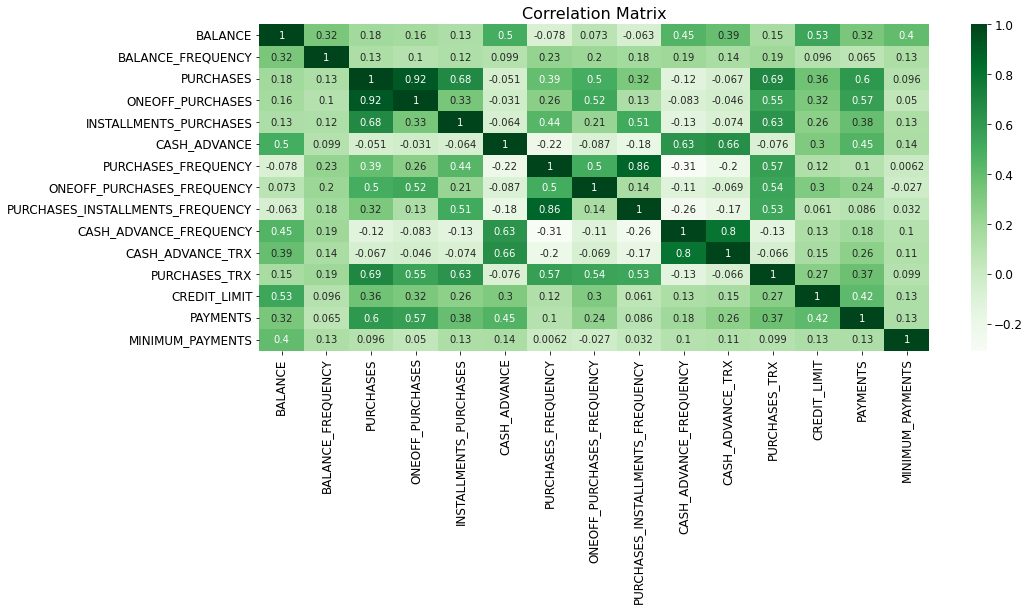

In [25]:
plt.figure(figsize=(15, 6))
sns.heatmap(numerical_df.corr(), annot=True, cmap='Greens', cbar=True)
plt.title("Correlation Matrix")
plt.show()

#### Relations with the target variable - IS_RISKY_PAYER

In [26]:
# Comparing the means
grouped_means = df.groupby('IS_RISKY_PAYER').mean()
grouped_means

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE
IS_RISKY_PAYER,,,,,,,,,,,,,,,,
0,1966.420482,0.898171,1303.809099,764.945009,539.151495,1456.074442,0.555931,0.235099,0.419533,0.174079,4.482974,18.052186,5597.196293,2402.589822,1128.102195,11.567197
1,1064.134652,0.851254,629.013970,377.700625,251.629433,384.850514,0.408716,0.161826,0.295854,0.086678,1.712566,10.549285,3121.380218,899.820464,492.386347,11.455229


In [27]:
# Comparing the medians 
grouped_medians = df.groupby('IS_RISKY_PAYER').median()
grouped_medians

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE
IS_RISKY_PAYER,,,,,,,,,,,,,,,,
0,706.182752,1.0,475.00,57.0,178.15,148.986635,0.583333,0.083333,0.333333,0.083333,1.0,10.0,5000.0,1359.022794,276.074313,12.0
1,969.139152,1.0,246.64,12.0,0.00,0.000000,0.250000,0.083333,0.000000,0.000000,0.0,4.0,2500.0,540.022225,312.343947,12.0


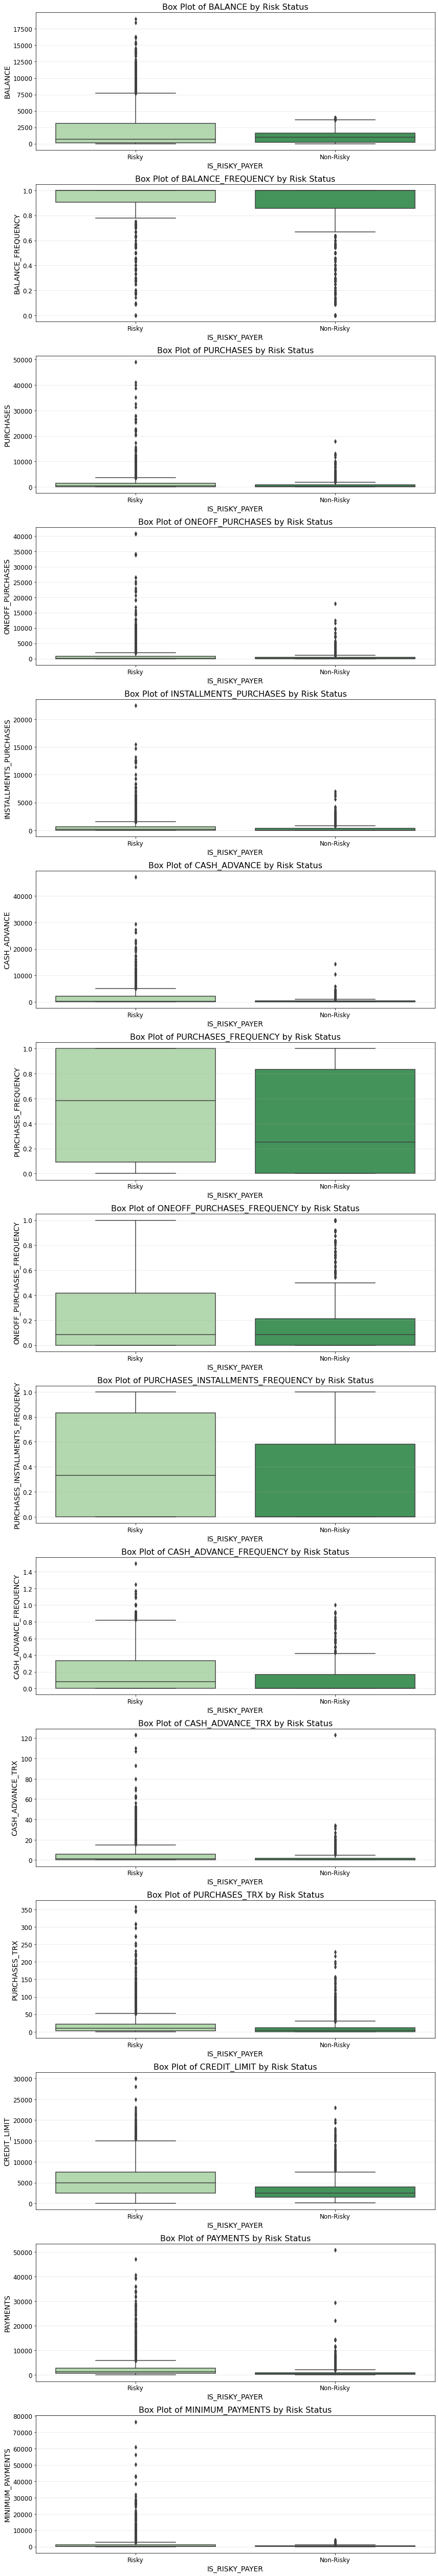

In [28]:
plt.figure(figsize=(12, 70))
for i, metric in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)
    sns.boxplot(data=df, x='IS_RISKY_PAYER', y=metric, palette="Greens")
    plt.title(f'Box Plot of {metric} by Risk Status')
    plt.xticks([0, 1], ["Risky", "Non-Risky"]) 
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

[balance, one-off purchases, installment purchases, cash advance, and minimum payments] demonstrate the most noticeable differences between risky and non-risky groups, primarily through the presence of outliers in the risky category. These features could therefore be strong indicators of risky payers when modeling.

In [30]:
risky_payers = df[df['IS_RISKY_PAYER'] == 0]
non_risky_payers = df[df['IS_RISKY_PAYER'] == 1]

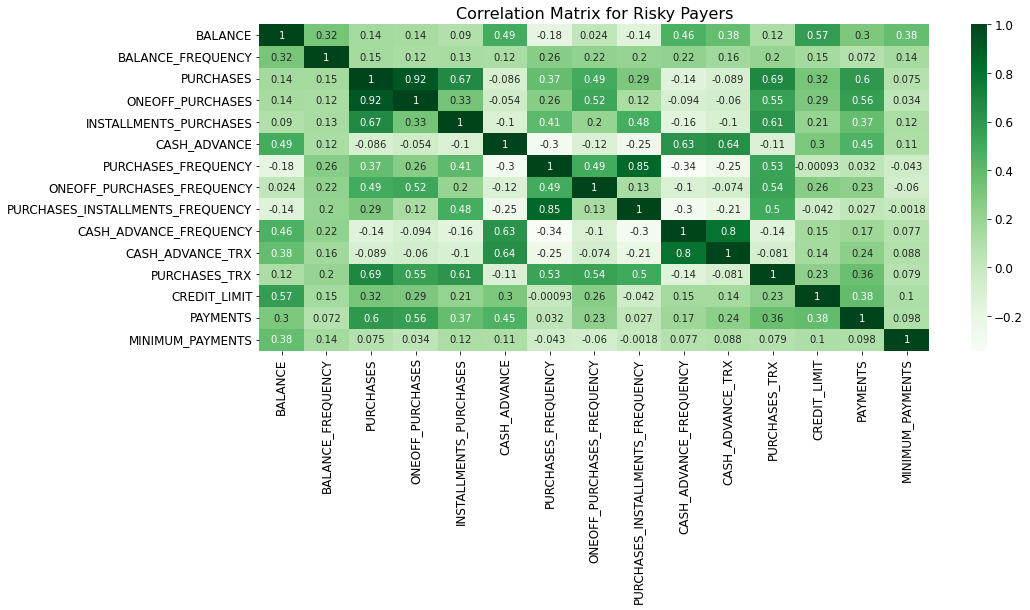

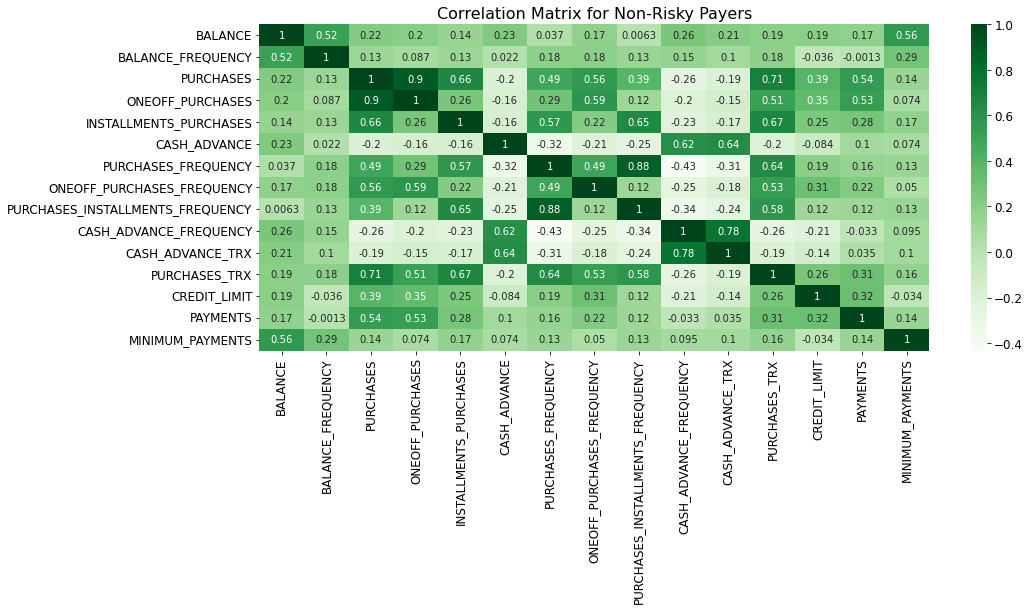

In [32]:
risky_corr = risky_payers.drop(columns=['IS_RISKY_PAYER', 'TENURE'], axis=1).corr()
non_risky_corr = non_risky_payers.drop(columns=['IS_RISKY_PAYER', 'TENURE'], axis=1).corr()


plt.figure(figsize=(15, 6))
sns.heatmap(risky_corr, annot=True, cmap='Greens', cbar=True)
plt.title("Correlation Matrix for Risky Payers")
plt.show()

plt.figure(figsize=(15, 6))
sns.heatmap(non_risky_corr, annot=True, cmap='Greens', cbar=True)
plt.title("Correlation Matrix for Non-Risky Payers")
plt.show()

the most notable difference in correlations is between balance with minimum payments and balance frequency, the correlation is higher for the risky payers than the non risky payers.  

Categorical features and target variable

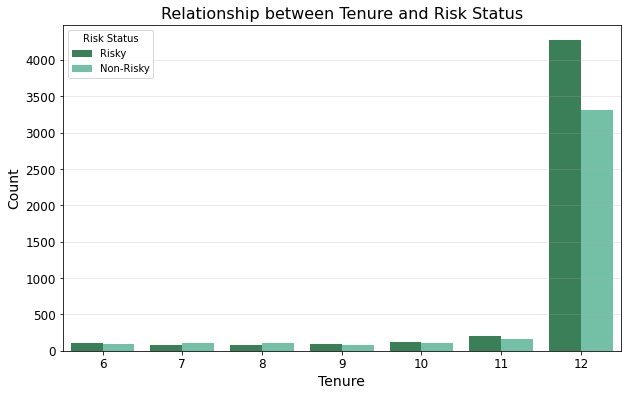

In [35]:
sns.countplot(data=df, x='TENURE', hue='IS_RISKY_PAYER')
plt.title("Relationship between Tenure and Risk Status")
plt.xlabel("Tenure")
plt.ylabel("Count")
plt.legend(title="Risk Status", labels=["Risky", "Non-Risky"])
plt.show()

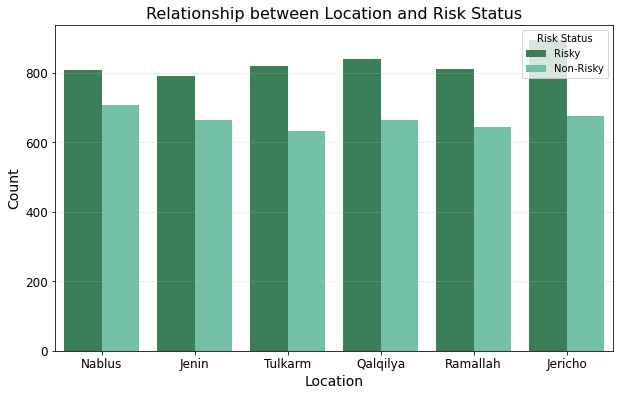

In [33]:
sns.countplot(data=df, x='LOCATION', hue='IS_RISKY_PAYER')
plt.title("Relationship between Location and Risk Status")
plt.xlabel("Location")
plt.ylabel("Count")
plt.legend(title="Risk Status", labels=["Risky", "Non-Risky"])
plt.show()

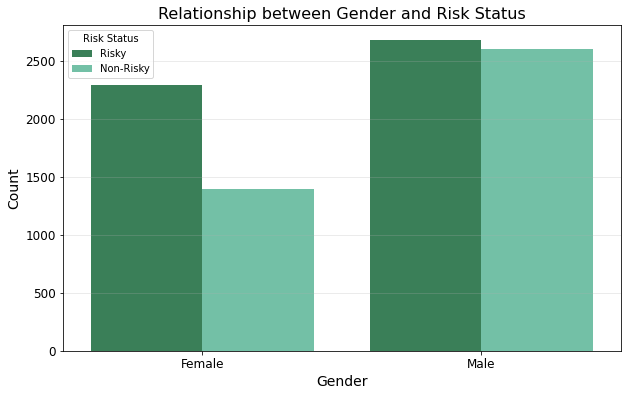

In [34]:
sns.countplot(data=df, x='GENDER', hue='IS_RISKY_PAYER')
plt.title("Relationship between Gender and Risk Status")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Risk Status", labels=["Risky", "Non-Risky"])
plt.show()

### Features Engineering

In [38]:
# encoding the categorical features. 
df['GENDER'] = df['GENDER'].map({'Male':0, 'Female':1})
df['LOCATION'] = df['LOCATION'].map({'Nablus':0, 'Jenin':1, 'Tulkarm':2, 'Qalqilya':3, 'Ramallah':4, 'Jericho':5})

In [39]:
features = numerical_features + ['GENDER','TENURE','LOCATION']
features

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'GENDER',
 'TENURE',
 'LOCATION']

Suggested New features: 
1. Ratio of balance to credit limit; high values may indicate credit overutilization and increased risk
2. Ratio of payments to balance; low values could suggest inconsistent payment behavior
3. Ratio of cash advances to purchases; higher values indicate reliance on cash advances, potentially showing financial strain
4. Ratio of installments to one-off purchases; shows preference for structured payments over single, large purchases
5. Ratio of purchases frequency to one-off purchases frequency; higher values indicate more consistent spending behavior
6. Binary feature indicating if user pays only minimum payments; can show possible financial strain or risk of default
7. Ratio of balance to min payments; how much of their balance the customer is paying as a minimum. Risky payers with a high balance but low minimum payments could be identified

In [40]:
# note: adding 1 to avoid division by zero
df['Credit_Utilization_Ratio'] = df['BALANCE'] / (df['CREDIT_LIMIT'] + 1)
df['Payment_to_Balance_Ratio'] = df['PAYMENTS'] / (df['BALANCE'] + 1)
df['Cash_Advance_to_Purchases_Ratio'] = df['CASH_ADVANCE'] / (df['PURCHASES'] + 1)
df['Installments_to_OneOff_Ratio'] = df['INSTALLMENTS_PURCHASES'] / (df['ONEOFF_PURCHASES'] + 1)
df['Spending_Consistency'] = df['PURCHASES_FREQUENCY'] / (df['ONEOFF_PURCHASES_FREQUENCY'] + 1)
df['Min_Payment_Indicator'] = (df['MINIMUM_PAYMENTS'] == df['BALANCE']).astype(int)
df['BALANCE_MIN_PAYMENT_RATIO'] = df['BALANCE'] / (df['MINIMUM_PAYMENTS'] + 1)  

In [42]:
df.describe()

,GENDER,LOCATION,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,...,MINIMUM_PAYMENTS,TENURE,IS_RISKY_PAYER,Credit_Utilization_Ratio,Payment_to_Balance_Ratio,Cash_Advance_to_Purchases_Ratio,Installments_to_OneOff_Ratio,Spending_Consistency,Min_Payment_Indicator,BALANCE_MIN_PAYMENT_RATIO
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,...,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.0,8950.000000
mean,0.410950,2.518994,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,...,844.906767,11.517318,0.445475,0.388663,16.120941,458.413426,136.964799,0.394868,0.0,2.161788
std,0.492034,1.722582,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,...,2332.792322,1.338331,0.497046,0.388162,205.549987,1447.952098,500.514934,0.335737,0.0,1.679959
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.019163,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,1.000000,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,...,170.857654,12.000000,0.000000,0.041485,0.329309,0.000000,0.000000,0.076923,0.0,0.653345
50%,0.000000,3.000000,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,...,312.343947,12.000000,0.000000,0.302493,1.400489,0.000000,0.227049,0.384616,0.0,2.098568
75%,1.000000,4.000000,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,...,788.713501,12.000000,1.000000,0.717229,7.532226,19.192148,31.464554,0.631579,0.0,3.394258
max,1.000000,5.000000,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,...,76406.207520,12.000000,1.000000,15.597991,14229.882480,26194.049540,22500.000000,1.000000,0.0,29.248131


In [41]:
df['Min_Payment_Indicator'].unique()

array([0])

In [43]:
df.drop(columns='Min_Payment_Indicator', inplace=True)

In [44]:
engineered_features = ['Credit_Utilization_Ratio', 'Payment_to_Balance_Ratio', 
                        'Cash_Advance_to_Purchases_Ratio', 'Installments_to_OneOff_Ratio', 
                        'Spending_Consistency', 'BALANCE_MIN_PAYMENT_RATIO']

In [45]:
features = features + engineered_features + ['IS_RISKY_PAYER']
features

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'GENDER',
 'TENURE',
 'LOCATION',
 'Credit_Utilization_Ratio',
 'Payment_to_Balance_Ratio',
 'Cash_Advance_to_Purchases_Ratio',
 'Installments_to_OneOff_Ratio',
 'Spending_Consistency',
 'BALANCE_MIN_PAYMENT_RATIO',
 'IS_RISKY_PAYER']

In [46]:
correlations = df.corr()['IS_RISKY_PAYER']
new_feature_corrs = correlations[engineered_features]
new_feature_corrs

Credit_Utilization_Ratio           0.156297
Payment_to_Balance_Ratio           0.024226
Cash_Advance_to_Purchases_Ratio   -0.115898
Installments_to_OneOff_Ratio      -0.075221
Spending_Consistency              -0.153958
BALANCE_MIN_PAYMENT_RATIO          0.068192
Name: IS_RISKY_PAYER, dtype: float64

### Modeling

In [47]:
df = df[features]

Exp 1: modeling without scaling the features. 

In [48]:
# Define features and target variable
features = df.drop(columns=['IS_RISKY_PAYER'])
target = df['IS_RISKY_PAYER']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

Training a Random Forest Model and checking features importance through it.

In [50]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=features.columns)
new_feature_importance = feature_importances[engineered_features]
print(new_feature_importance.sort_values(ascending=False))

Payment_to_Balance_Ratio           0.125535
Credit_Utilization_Ratio           0.059172
BALANCE_MIN_PAYMENT_RATIO          0.050483
Cash_Advance_to_Purchases_Ratio    0.031383
Spending_Consistency               0.024658
Installments_to_OneOff_Ratio       0.017012
dtype: float64


In [55]:
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print('Accuracy: ',accuracy, '\nROC AUC:', roc_auc)
print(classification_rep)

Accuracy:  0.897951582867784 
ROC AUC: 0.8955183796788452
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1465
           1       0.90      0.87      0.89      1220

    accuracy                           0.90      2685
   macro avg       0.90      0.90      0.90      2685
weighted avg       0.90      0.90      0.90      2685



Training Logestic Regression

In [56]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print('Accuracy: ',accuracy, '\nROC AUC:', roc_auc)
print(classification_rep)

Accuracy:  0.7582867783985102 
ROC AUC: 0.7560174564986292
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1465
           1       0.74      0.73      0.73      1220

    accuracy                           0.76      2685
   macro avg       0.76      0.76      0.76      2685
weighted avg       0.76      0.76      0.76      2685



c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Exp 2: Try the models after scaling the features with Robust Scaler

In [57]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)       

In [58]:
robust_scaler = RobustScaler()
X_train_robust_scaled = robust_scaler.fit_transform(X_train)
X_test_robust_scaled = robust_scaler.transform(X_test)


Random Forest after Robust scaler

In [59]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_robust_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_robust_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print("Accuracy:", accuracy_rf)
print("ROC AUC Score:", roc_auc_rf)
print("Classification Report:\n", classification_rep_rf)

Accuracy: 0.8990689013035382
ROC AUC Score: 0.8967478878755665
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1465
           1       0.90      0.87      0.89      1220

    accuracy                           0.90      2685
   macro avg       0.90      0.90      0.90      2685
weighted avg       0.90      0.90      0.90      2685



Logestic Regression after Robust scaler

In [60]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_robust_scaled, y_train)

y_pred = log_reg.predict(X_test_robust_scaled)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_rep)

Accuracy: 0.7973929236499069
ROC AUC Score: 0.7943895820511385
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1465
           1       0.79      0.76      0.77      1220

    accuracy                           0.80      2685
   macro avg       0.80      0.79      0.80      2685
weighted avg       0.80      0.80      0.80      2685



In [61]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_robust_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_robust_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

print("Accuracy:", accuracy_xgb)
print("ROC AUC Score:", roc_auc_xgb)
print("Classification Report:\n", classification_rep_xgb)

c:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8934823091247672
ROC AUC Score: 0.8917655122251441
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1465
           1       0.89      0.87      0.88      1220

    accuracy                           0.89      2685
   macro avg       0.89      0.89      0.89      2685
weighted avg       0.89      0.89      0.89      2685



In [64]:
with open('best_random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Results

**Models Comparison**
1. Random Forest:
   - Precision/Recall: The model achieves strong precision and recall for both classes, with slightly higher recall for non-risky (class 0) and slightly lower for risky (class 1).
   - This model performs well with balanced precision and recall, which indicates it accurately identifies both risky and non-risky payers.

2. XGBoost:
   - Precision/Recall: XGBoost has similar performance to Random Forest, with a balanced recall and precision. However, recall for risky payers is slightly lower, which means it it misses a few more risky payers compared to Random Forest.

3. Logistic Regression:
   - Precision/Recall: Logistic Regression has noticeably lower accuracy, precision, and recall, particularly for the risky class (class 1).
   - Worst performance 

**Metric Insights**
- Accuracy: Both Random Forest and XGBoost achieve high accuracy (~90%).
- ROC AUC: Both models display strong class separation, with Random Forest performing slightly better.

**Scaling Impact** <br>
Random Forest shows strong performance with or without scaling, while Logistic Regression benefits from scaling. 

**Suggestions for Improvement**
1. Hyperparameter Tuning: Optimize parameters (e.g., `n_estimators`, `max_depth`).
2. Feature Engineering:
   - Add transformations or interaction features, focusing on risky payers.
   - Create new ratios or aggregated features related to spending and payment behavior.
3. Ensemble Methods: Combine Random Forest and XGBoost to leverage their strengths.